### Импорт зависимостей

In [99]:
import os
import random
import shutil
from pathlib import Path

import kagglehub
from kagglehub import KaggleDatasetAdapter

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt

### Загрузка датасета

In [101]:
dataset_path = kagglehub.dataset_download('harishekar/chess-board-state-detection-dataset')
dataset_path

'C:\\Users\\rayshite\\.cache\\kagglehub\\datasets\\harishekar\\chess-board-state-detection-dataset\\versions\\1'

### Разделение данных на обучающюю, валидационную и тестовую выборки

In [103]:
SRC_DIR = Path(dataset_path) / "final_original_dataset"
DEST_DIR = Path("data")

# доли выборок
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

random.seed(42)

for class_dir in SRC_DIR.iterdir():
    if not class_dir.is_dir():
        continue

    class_name = class_dir.name 
    images = [p for p in class_dir.iterdir() if p.is_file()]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val  # остаток уходит в test

    splits = {
        "train": images[:n_train],
        "val":   images[n_train:n_train + n_val],
        "test":  images[n_train + n_val:],
    }

    for split_name, split_files in splits.items():
        target_dir = DEST_DIR / split_name / class_name
        target_dir.mkdir(parents=True, exist_ok=True)

        for src_path in split_files:
            dst_path = target_dir / src_path.name
            shutil.copy2(src_path, dst_path)

    print(f"{class_name}: total={n_total}, train={n_train}, val={n_val}, test={n_test}")

bB: total=100, train=70, val=15, test=15
bK: total=100, train=70, val=15, test=15
bN: total=100, train=70, val=15, test=15
bP: total=100, train=70, val=15, test=15
bQ: total=100, train=70, val=15, test=15
bR: total=100, train=70, val=15, test=15
empty: total=100, train=70, val=15, test=15
wB: total=100, train=70, val=15, test=15
wK: total=100, train=70, val=15, test=15
wN: total=100, train=70, val=15, test=15
wP: total=100, train=70, val=15, test=15
wQ: total=100, train=70, val=15, test=15
wR: total=100, train=70, val=15, test=15


### Создание базовой модели

In [105]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(13, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [107]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13)             │       163,085 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,141,581 (4.35 MB)

 Trainable params: 1,141,581 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
model.compile(loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [111]:
train_dataset = image_dataset_from_directory(
    DEST_DIR / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    DEST_DIR / "val",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    DEST_DIR / "test",
    image_size=(180, 180),
    batch_size=32)

Found 910 files belonging to 13 classes.
Found 195 files belonging to 13 classes.
Found 195 files belonging to 13 classes.


### Обучение базовой модели

In [113]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="model1.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.1132 - loss: 2.5061 - val_accuracy: 0.2000 - val_loss: 2.1779
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 284ms/step - accuracy: 0.2242 - loss: 1.9191 - val_accuracy: 0.2154 - val_loss: 2.1120
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 0.3209 - loss: 1.7452 - val_accuracy: 0.2974 - val_loss: 1.7070
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - accuracy: 0.3989 - loss: 1.8340 - val_accuracy: 0.3744 - val_loss: 1.6759
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 0.4890 - loss: 1.3551 - val_accuracy: 0.3641 - val_loss: 2.3248
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy: 0.5429 - loss: 1.2539 - val_accuracy: 0.3949 - val_loss: 1.7111
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - accuracy: 0.5879 - loss: 1.0925 - val_accuracy: 0.4769 - val_loss: 1.4199
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - accuracy: 0.5967 - loss: 1.0715 - val_accuracy: 0

### Визуализация обучения базовой модели

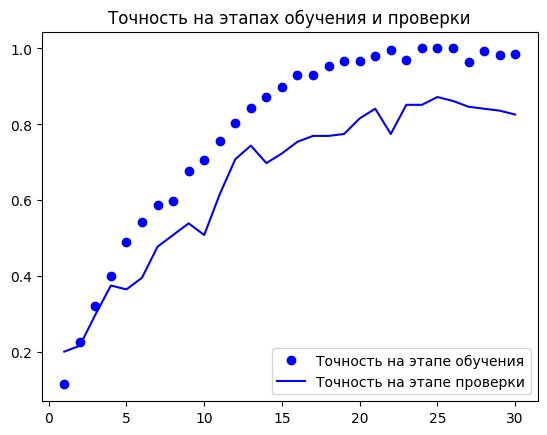

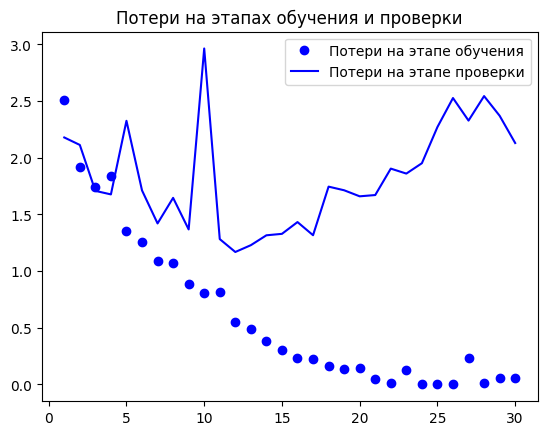

In [115]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Точность на этапе обучения")
plt.plot(epochs, val_accuracy, "b", label="Точность на этапе проверки")
plt.title("Точность на этапах обучения и проверки")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Потери на этапе обучения")
plt.plot(epochs, val_loss, "b", label="Потери на этапе проверки")
plt.title("Потери на этапах обучения и проверки")
plt.legend()
plt.show()

In [117]:
model = keras.models.load_model("model1.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Точность на тестовых данных: {test_acc:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6974 - loss: 1.0666 
Точность на тестовых данных: 0.697


### Обогащение данных


In [122]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(0.1, 0.1), 
        layers.RandomBrightness(0.2),
    ]
)

### Создание модели с обогащением с прореживанием


In [130]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(13, activation="softmax")(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.compile(loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

### Обучение улучшенной модели

In [132]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="model2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model2.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - accuracy: 0.0934 - loss: 2.6317 - val_accuracy: 0.1641 - val_loss: 2.5104
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.1791 - loss: 2.3052 - val_accuracy: 0.2769 - val_loss: 1.9095
Epoch 3/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 0.2407 - loss: 2.0521 - val_accuracy: 0.2359 - val_loss: 1.9011
Epoch 4/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 0.2714 - loss: 1.9799 - val_accuracy: 0.2718 - val_loss: 1.7573
Epoch 5/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 0.3275 - loss: 1.7521 - val_accuracy: 0.3128 - val_loss: 1.6768
Epoch 6/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.3418 - loss: 1.6842 - val_accuracy: 0.3487 - val_loss: 1.6326
Epoch 7/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.3791 - loss: 1.6376 - val_accuracy: 0.3333 - val_loss: 1.6638
Epoch 8/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.4088 - loss: 1.5588 - val_accuracy: 

### Визуализация обучения улучшенной модели

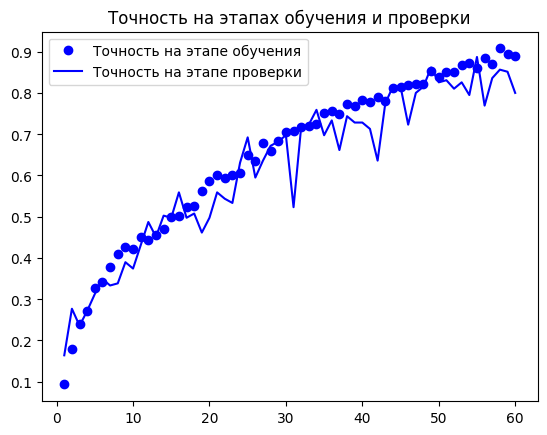

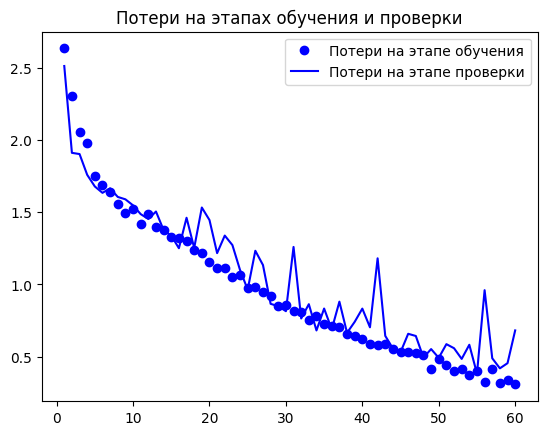

In [139]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Точность на этапе обучения")
plt.plot(epochs, val_accuracy, "b", label="Точность на этапе проверки")
plt.title("Точность на этапах обучения и проверки")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Потери на этапе обучения")
plt.plot(epochs, val_loss, "b", label="Потери на этапе проверки")
plt.title("Потери на этапах обучения и проверки")
plt.legend()
plt.show()

In [141]:
test_mode2 = keras.models.load_model(
    "model2.keras")
test_loss, test_acc = test_mode2.evaluate(test_dataset)
print(f"Точность на тестовых данных: {test_acc:.3f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8821 - loss: 0.4168
Точность на тестовых данных: 0.882
